In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("../mpi_scripts/")
from io_utils import collect_results
#plt.style.use(default)

sys.path.append('src/model')
from ina_model import InaModel
from solmodel import SolModel
import os

In [2]:
plt.style.use("../../styles/general.mplstyle")


In [3]:
def give_m_h(v_m,params):
    m_inf = 1 / (1 + np.exp(-(params.v_half_m + v_m) / params.k_m))
    h_inf = 1 / (1 + np.exp((params.v_half_h + v_m) / params.k_h))
    return {'m': m_inf,
            'h': h_inf}

In [4]:
def give_tau(v_m, params):
    tau_m = 1 / (params.a0_m * np.exp(v_m / params.s_m) + params.b0_m * np.exp(- v_m / params.delta_m))
    tau_h = 1 / (params.a0_h * np.exp(-v_m / params.s_h) + params.b0_h * np.exp(v_m / params.delta_h))
    tau_j = params.tau_j_const + 1 / (params.a0_j * np.exp(-v_m / params.s_j) + params.b0_j * np.exp(v_m / params.delta_j))
    return {'tau_m': tau_m,
            'tau_h': tau_h,
            'tau_j': tau_j,
           }

In [5]:
sys.path.append('../pypoptim/mpi_scripts/')
from ina_model import InaModel

dirname = '../../src/model_ctypes/ina_pipette/'
filename_so = os.path.join(dirname, 'ina.so')

filename_so_abs = os.path.abspath(filename_so)
INA = InaModel(filename_so_abs)

In [6]:
C = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value'] 
S = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value'] 
A = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value'] 

In [7]:
df_protocol = pd.read_csv('../../data/protocols/protocol_trace.csv')
df_initial_state_protocol = pd.read_csv('../../data/protocols/protocol_initial_state.csv')

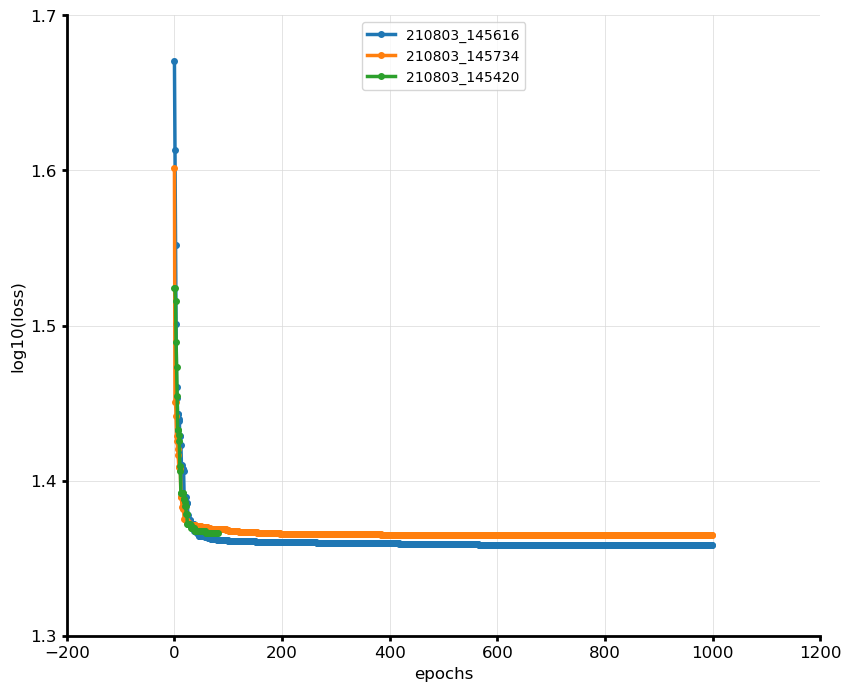

In [26]:
#cases = ['210802_172026', '210802_181719']
#cases = ['210802_194921', '210802_195302']
cases = [ '210803_145616', '210803_145734' , '210803_145420',]
dirname_results = '../../results/real_data/'
sol_best_list = []
phenotype_best_list = []
for case in cases:
    #result = collect_results(case, dirname_results, dump_keys=['best'])
    result = collect_results(case, dirname_results, dump_keys=['best'])#, 'dump'])
    config = result['config'].copy()
    sol_best = result['sol_best'].copy()
    sol_best_list.append(sol_best)
    phenotype_best = result['phenotype_best'].copy()
    phenotype_best_list.append(phenotype_best)
    loss = result['dump']['best']['loss']
    #assert np.all(np.diff(loss)<=0)
    
    plt.plot(np.log10(loss), '.-', label = case)
plt.xlabel('epochs')
plt.ylabel('log10(loss)')
plt.legend()
# plt.xlim(0,56)



In [20]:
training_data = pd.read_csv('../../data/training/2020_12_19_0035.csv')

/tmp/ipykernel_4719/467472124.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()
/tmp/ipykernel_4719/467472124.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()
/tmp/ipykernel_4719/467472124.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


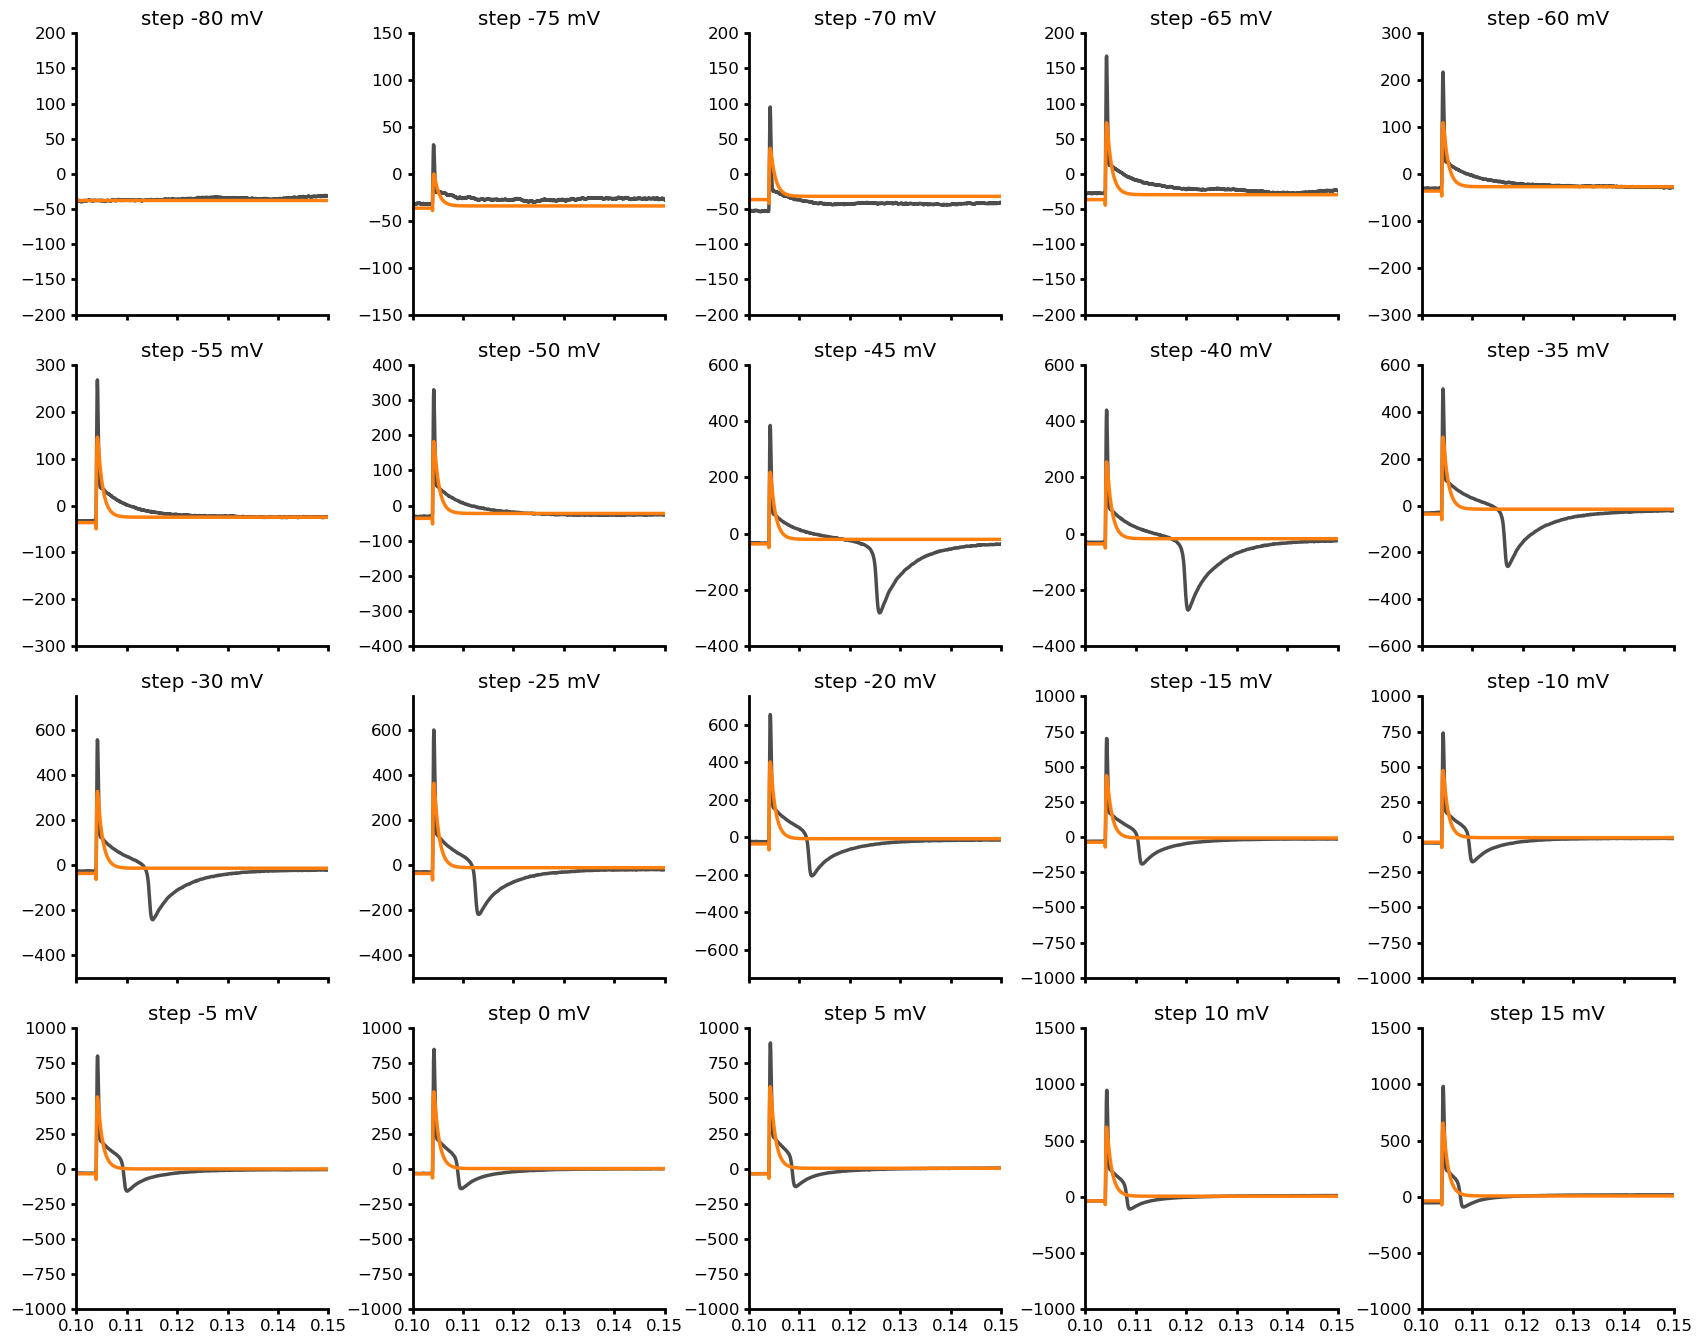

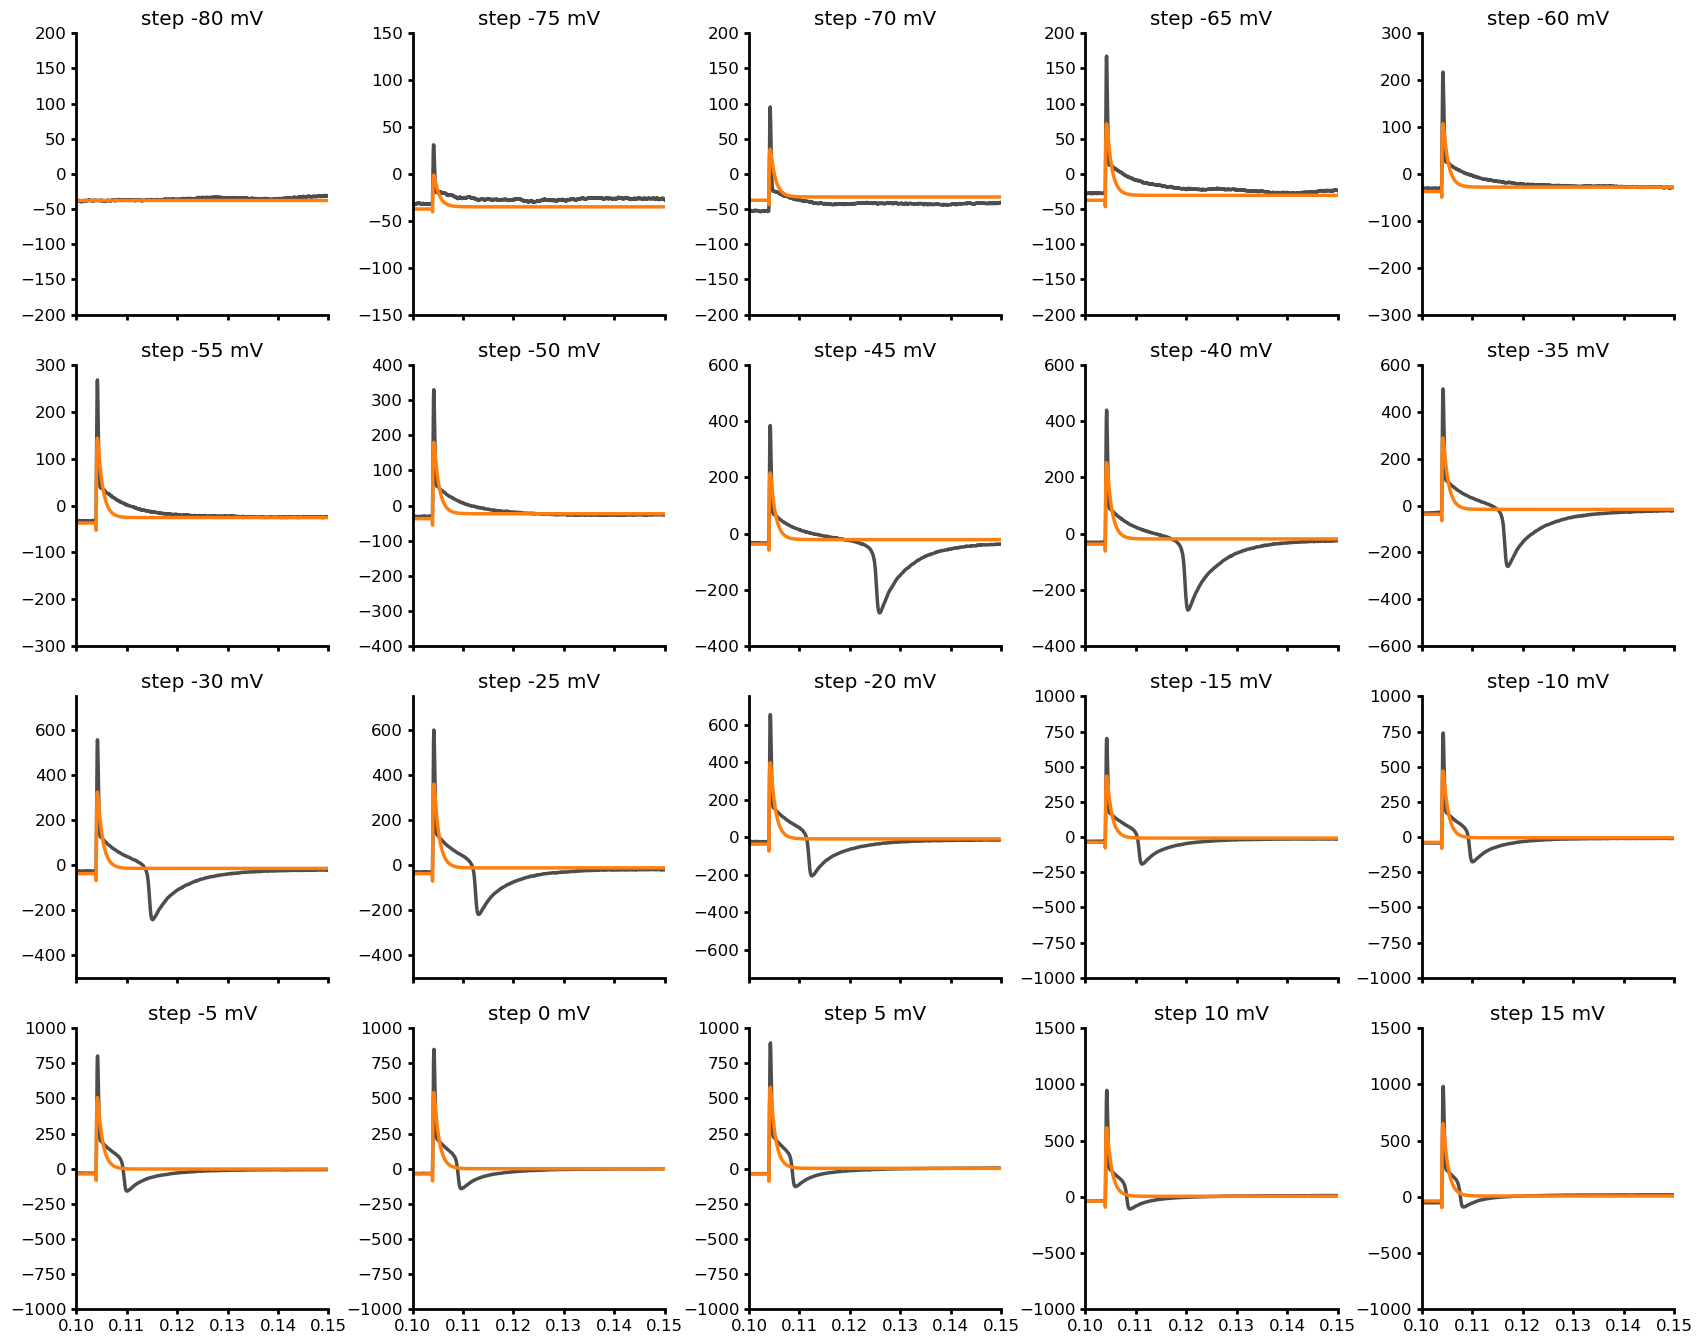

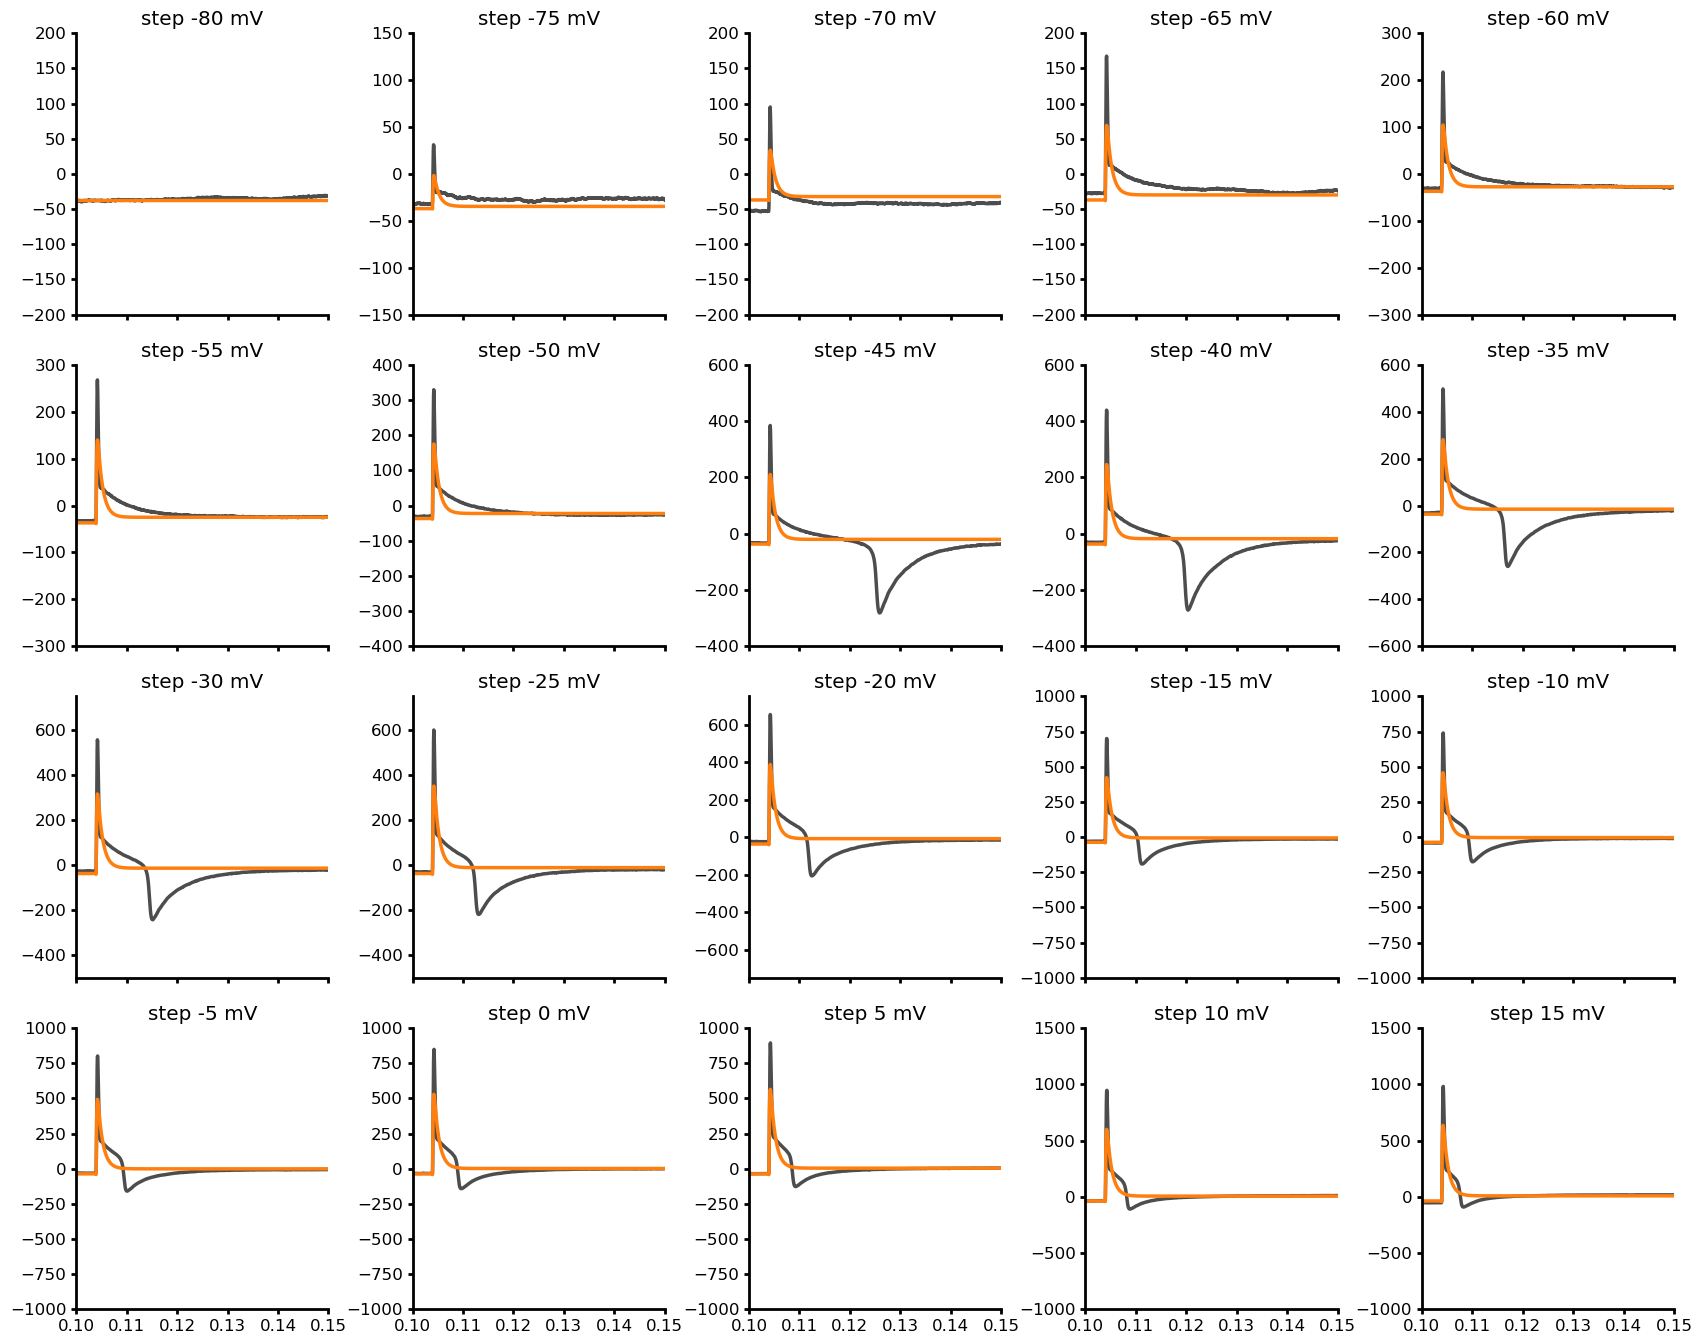

In [28]:
for phenotype in phenotype_best_list:
    I_out = phenotype['trace'].I_out # A.I_out
    real_data_all = training_data.I_out
    n_sections = 20
    split_indices = np.linspace(0, len(real_data_all), n_sections + 1).astype(int)

    nrows, ncols = 4, 5

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 2,
                             sharex=True)

    
    dt = 5e-5

    colors = ['0.3', 'C1', 'C2','C3']

    i_global = 0

    for i_row in range(nrows):
        for i_col in range(ncols):
            ax = axes[i_row, i_col]
            plt.sca(ax)

            i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
            slice_current = slice(i_start, i_end)

            I_out_current = I_out[slice_current]
            data_current  = real_data_all[slice_current]
            t = np.arange(len(data_current)) * dt

            plt.plot(t, data_current,  color=colors[0])
            plt.plot(t, I_out_current,  color=colors[1])
            
            plt.grid()

            step_value = -80 + 5 * i_global
            title = f'step {step_value} mV'
            plt.title(title)

            i_global += 1
            plt.xlim(0.10,0.15)
            #plt.ylim(-1500,1500)
            
    plt.tight_layout()

In [250]:
# names of genes
m_index = config['runtime']['m_index']
dump_genes = result['dump']['dump']['genes'].reshape((-1, len(m_index)))
n_organisms = config['runtime']['n_organisms']
n_generations = len(dump_genes) // n_organisms
# multiindex (generation, numb_of_organism) 
index = pd.MultiIndex.from_product([range(n_generations), range(n_organisms)],
                                   names=['epoch', 'org'])

dump_genes = pd.DataFrame(dump_genes, columns=m_index, index=index)

dump_loss = result['dump']['dump']['loss'].reshape((n_generations, config['runtime']['n_organisms']))
epochs = []
for k in range(n_generations):
    for l in range(n_organisms):
        epochs.append(k)

In [251]:
lab = ['c_p', 'c_m', 'a0_m', 'b0_m', 'delta_m', 's_m', 'a0_h', 'b0_h', 'delta_h', 's_h', 'a0_j', 'b0_j', 'delta_j', 's_j', 'tau_j_const', 'R', 'R_f', 'g_max', 'g_leak', 'tau_z', 'v_half_m', 'v_half_h', 'k_m', 'k_h', 'x_c_comp', 'x_r_comp', 'alpha']

In [23]:
V = np.arange(-100, 20)
real_m_h = give_m_h(V, C)
real_tau = give_tau(V, C)

real_data_list =  [[real_m_h['m'], real_m_h['h'] ],
                  [real_tau['tau_m']],
                  [real_tau['tau_h']],
                  [real_tau['tau_j']]]

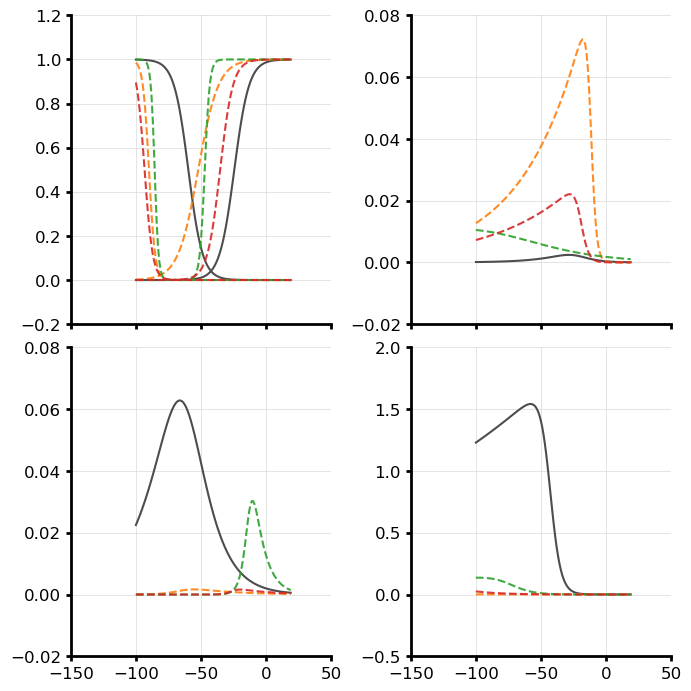

In [25]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols),
                             sharex=True)

axes = axes.flatten()

for items, ax in zip(real_data_list, axes):
    for item in items:
        ax.plot(V, item,alpha = 1,color = colors[0], lw = 1.5)
col = 0
for sol_best in sol_best_list[:]:
    col +=1
    K = pd.concat([sol_best['common'][:-7]*C[:-10],sol_best['common'][-7:]])
    m_h = give_m_h(V, K)
    tau = give_tau(V, K)


    items_list = [[m_h['m'], m_h['h'] ],
                  [tau['tau_m']],
                  [tau['tau_h']],
                  [tau['tau_j']]]

 
    
    labels_list = [['m_inf GA', 'h_inf GA'],
                   ['tau_m GA'],
                   ['tau_h GA'],
                   ['tau_j GA']]
    
            
    for items, ax, labels in zip(items_list, axes, labels_list):
        for item, label in zip(items, labels):
            ax.plot(V, item,lw = 1.5, alpha=0.9, linestyle = "--", color = colors[col])


In [8]:
art_data = pd.read_csv('../../data/training/art_data_right_j_pipette.csv')

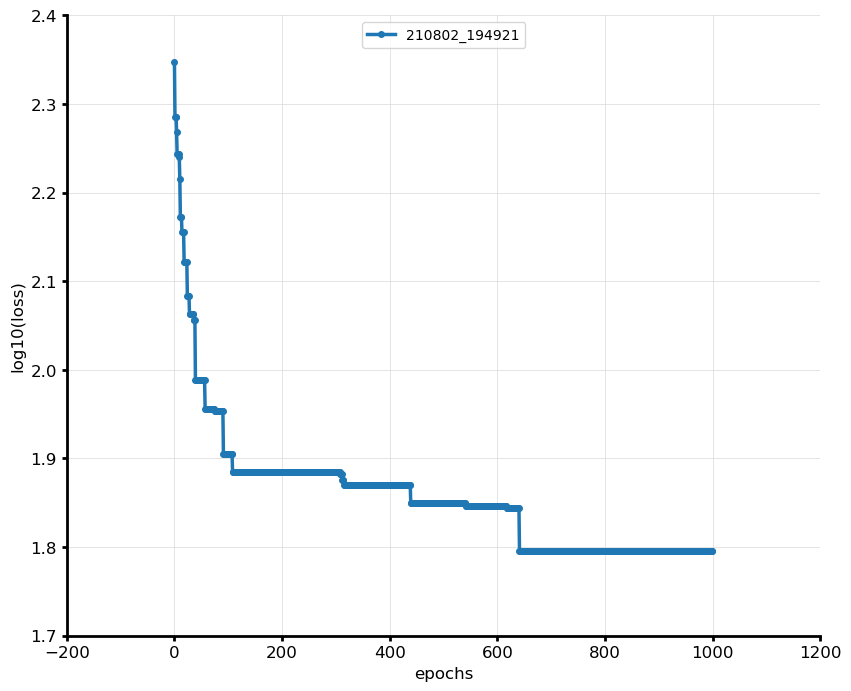

In [9]:
cases = ['210802_194921']
dirname_results = '../../results/ina_pipette/'
sol_best_list = []
phenotype_best_list = []
for case in cases:
    #result = collect_results(case, dirname_results, dump_keys=['best'])
    result = collect_results(case, dirname_results, dump_keys=['best', 'dump'])
    config = result['config'].copy()
    sol_best = result['sol_best'].copy()
    sol_best_list.append(sol_best)
    phenotype_best = result['phenotype_best'].copy()
    phenotype_best_list.append(phenotype_best)
    loss = result['dump']['best']['loss']
    #assert np.all(np.diff(loss)<=0)
    
    plt.plot(np.log10(loss), '.-', label = case)
plt.xlabel('epochs')
plt.ylabel('log10(loss)')
plt.legend()
# plt.xlim(0,56)



In [10]:
sol_best

ec_name  g_name     
common   c_p             5.239363
         c_m             0.458736
         a0_m            0.265581
         b0_m            2.930237
         delta_m         3.003511
         s_m             9.002463
         a0_h            0.128229
         b0_h            0.609097
         delta_h         0.706099
         s_h             1.288393
         a0_j            1.027603
         b0_j            3.446424
         delta_j         0.813104
         s_j             5.275256
         tau_j_const     1.681210
         R               1.073007
         R_f             0.631355
         g_max           1.145858
         g_leak          1.396984
         tau_z           5.444076
         v_half_m       23.220254
         v_half_h       89.833478
         k_m             6.472999
         k_h             7.821670
         x_c_comp        0.629880
         x_r_comp        0.378098
         alpha           0.768035
trace    v_off          -0.883895
Name: 0, dtype: float64

/tmp/ipykernel_18473/126356349.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


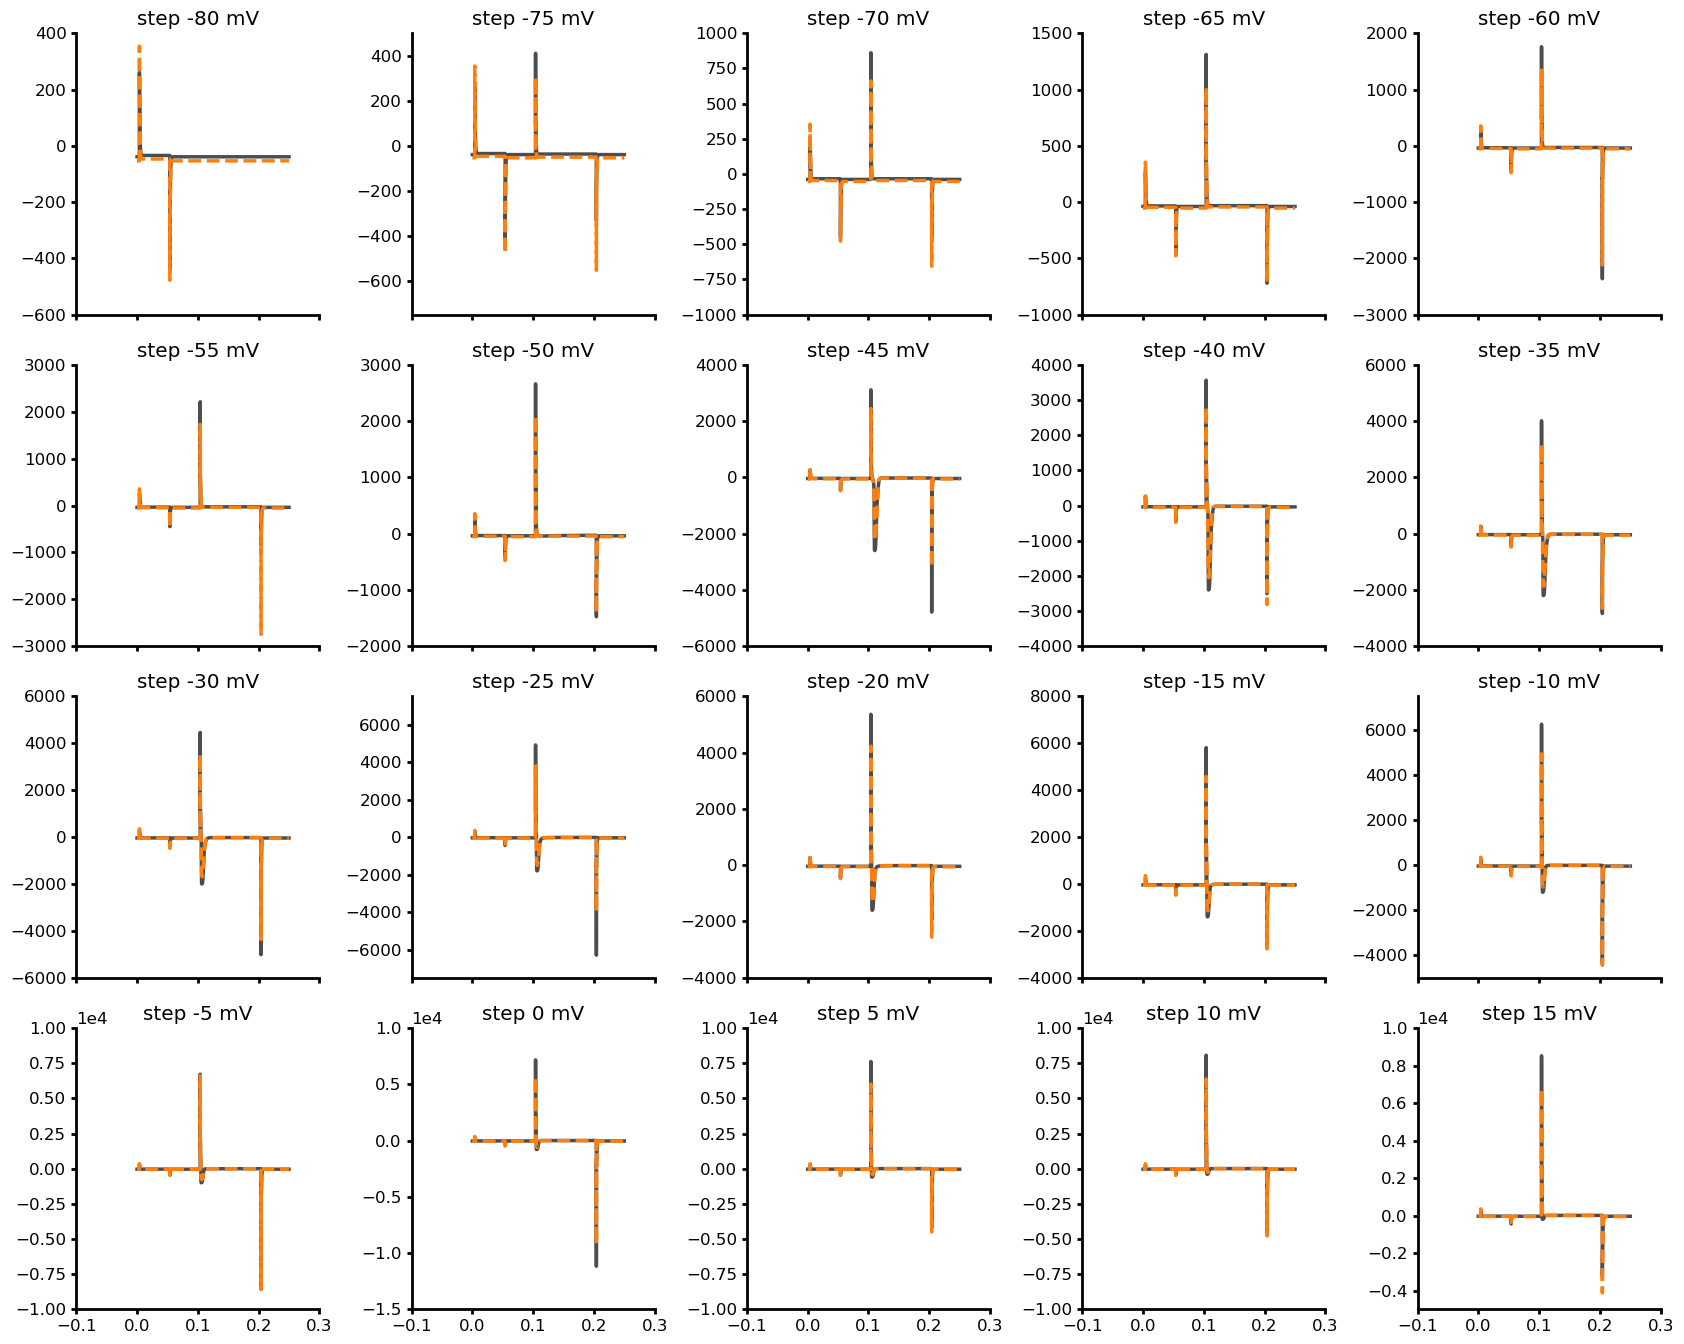

In [11]:
for phenotype in phenotype_best_list:
    I_out = phenotype['trace'].I_out # A.I_out
    real_data_all = art_data.I_out
    n_sections = 20
    split_indices = np.linspace(0, len(real_data_all), n_sections + 1).astype(int)

    nrows, ncols = 4, 5

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 2,
                             sharex=True)

    
    dt = 5e-5

    colors = ['0.3', 'C1']

    i_global = 0

    for i_row in range(nrows):
        for i_col in range(ncols):
            ax = axes[i_row, i_col]
            plt.sca(ax)

            i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
            slice_current = slice(i_start, i_end)

            I_out_current = I_out[slice_current]
            data_current  = real_data_all[slice_current]
            t = np.arange(len(data_current)) * dt

            plt.plot(t, data_current,  color=colors[0])
            plt.plot(t, I_out_current, "--", color=colors[1])
            
            plt.grid()

            step_value = -80 + 5 * i_global
            title = f'step {step_value} mV'
            plt.title(title)

            i_global += 1
            #plt.xlim(0.20350,0.2065)
            #plt.ylim(-1500,1500)
            
    plt.tight_layout()

In [21]:
config

{'n_organisms': 256,
 'n_elites': 16,
 'n_generations': 1000,
 'output_folder_name': '../../../results/ina_pipette/',
 'loss': 'RMSE',
 'columns_control': ['I_out'],
 'columns_model': ['I_out'],
 'column_stim_protocol': ['v'],
 'filename_so': '../../../src/model_ctypes/ina_pipette/ina.so',
 'filename_legend_states': '../../../src/model_ctypes/ina_pipette/legend_states.csv',
 'filename_legend_constants': '../../../src/model_ctypes/ina_pipette/legend_constants.csv',
 'filename_legend_algebraic': '../../../src/model_ctypes/ina_pipette/legend_algebraic.csv',
 'filename_protocol': '../../../data/protocols/protocol_trace.csv',
 'filename_initial_state_protocol': '../../../data/protocols/protocol_initial_state_x3.csv',
 'experimental_conditions': {'common': {'params': {'c_p': {'bounds': [0.1, 10],
     'gamma': 0.004,
     'is_multiplier': True},
    'c_m': {'bounds': [0.1, 10], 'gamma': 0.004, 'is_multiplier': True},
    'a0_m': {'bounds': [0.1, 10], 'gamma': 0.004, 'is_multiplier': True},
 

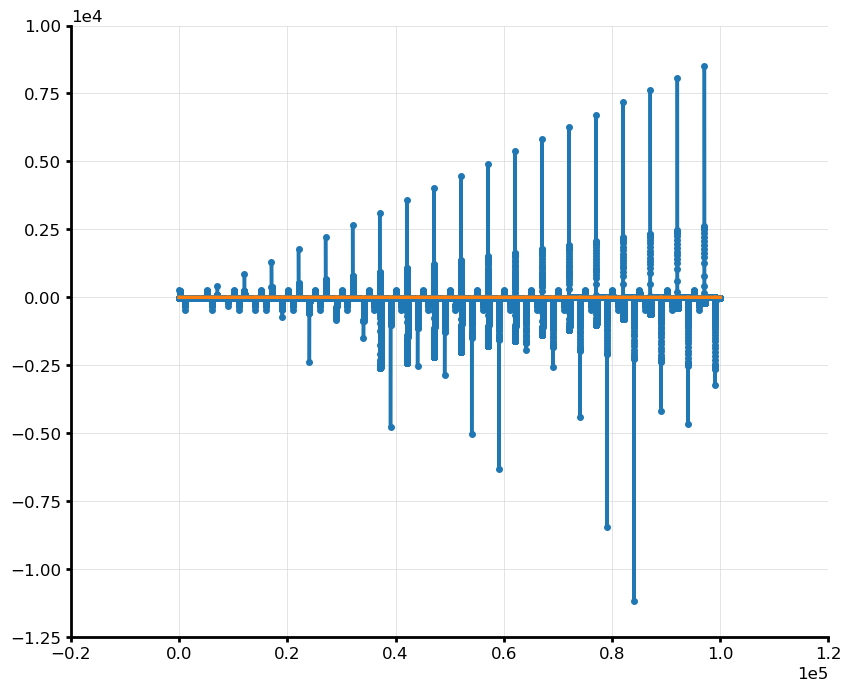

In [22]:
start = 9078
end = 9098
weight = np.zeros_like(art_data.I_out)
weight+=1   
for k in range(19):
    weight[start:end]*= 10
    start+=5000
    end+=5000
plt.plot(art_data.I_out, '.-')
plt.plot(weight)
#plt.axvline(9078, color = 'k')
#plt.axvline(9098, color = 'k')
#plt.xlim(start,end)
#plt.ylim(-200,0)

In [222]:
#W = pd.DataFrame(np.array([art_data.t.values, weight]).T, columns=['t','w'])
#W.to_csv('../../data/sample_weights/weight_10_for_tails.csv')

(62075.0, 62200.0)

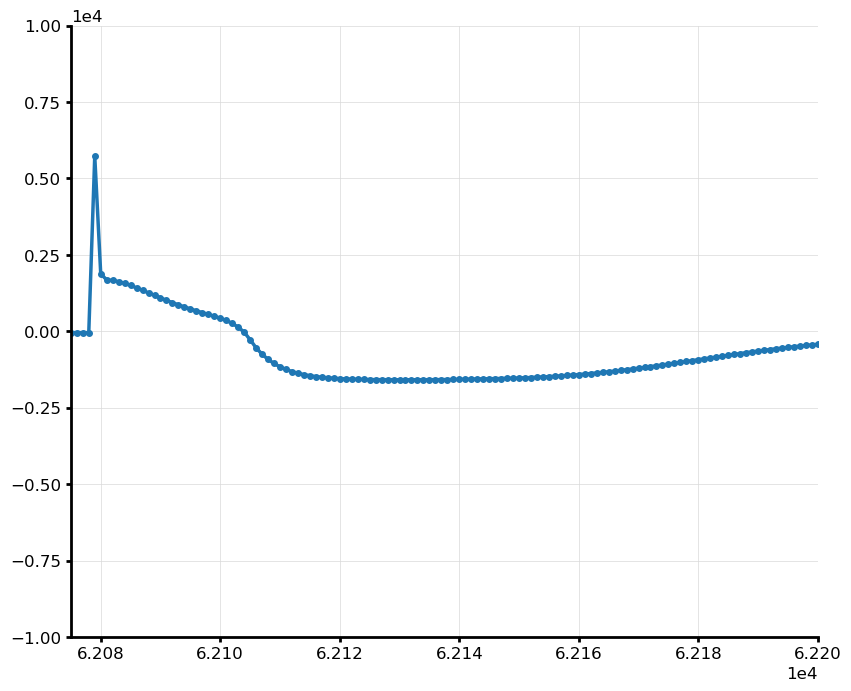

In [189]:
plt.plot(phenotype['trace'].I_out,'.-')
plt.xlim(62075,62200)

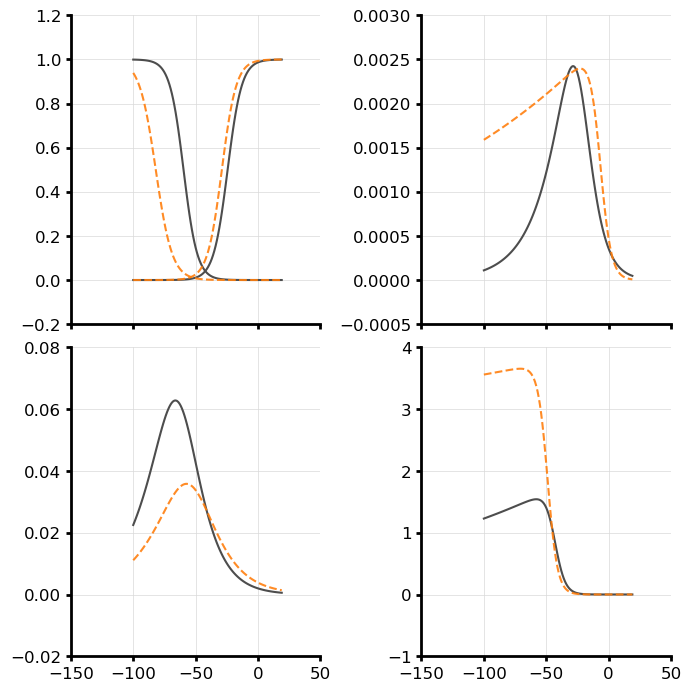

In [171]:
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols),
                             sharex=True)

axes = axes.flatten()

for items, ax in zip(real_data_list, axes):
    for item in items:
        ax.plot(V, item,alpha = 1,color = colors[0], lw = 1.5)

for sol_best in sol_best_list[:]:
    K = pd.concat([sol_best['common'][:-7]*C[:-10],sol_best['common'][-7:]])
    m_h = give_m_h(V, K)
    tau = give_tau(V, K)


    items_list = [[m_h['m'], m_h['h'] ],
                  [tau['tau_m']],
                  [tau['tau_h']],
                  [tau['tau_j']]]

 
    
    labels_list = [['m_inf GA', 'h_inf GA'],
                   ['tau_m GA'],
                   ['tau_h GA'],
                   ['tau_j GA']]
    
            
    for items, ax, labels in zip(items_list, axes, labels_list):
        for item, label in zip(items, labels):
            ax.plot(V, item,lw = 1.5, alpha=0.9, linestyle = "--", color = colors[1])


In [26]:
case = cases[0]#'210802_184040'
dirname_results = '../../results/ina_pipette/'


In [27]:
result = collect_results(case, dirname_results, dump_keys=['best', 'dump'])
config = result['config'].copy()
sol_best = result['sol_best'].copy()

In [28]:
sys.path.append('../mpi_scripts/')

In [12]:
sys.path.append('../mpi_scripts/')
from ina_model import InaModel
from solmodel import SolModel

In [13]:
filename_so = config['runtime']['filename_so_abs']
model = InaModel(filename_so)

SolModel.model = model
SolModel.config = config.copy()


In [14]:
filename_so = config['runtime']['filename_so_abs']
sol = SolModel(sol_best)

In [15]:
filename_so = config['runtime']['filename_so_abs']
InaModel(filename_so)

In [79]:
model = InaModel(filename_so)

In [77]:
df_protocol = pd.DataFrame(np.array([np.arange(0, 5, 5e-7)]).T, columns=['t'])

In [112]:
output, output2 = model.run(A,S,C,protocol_1,df_initial_state_protocol)

In [113]:
output2

name,tau_m,tau_h,tau_j,m_inf,h_inf,v_cp,I_leak,I_Na,I_c,I_p,I_comp,I_in
0,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-3.941645e-06,-1.771803e-11,0.000000,0.0,-38.993896
1,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-3.941644e-06,-1.757746e-11,0.000000,0.0,-38.993896
2,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-3.941644e-06,-1.757746e-11,0.000000,0.0,-38.993896
3,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-3.941644e-06,-1.757746e-11,0.000000,0.0,-38.993896
4,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-3.941644e-06,-1.757746e-11,0.000000,0.0,-38.993896
...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-7.658038e-08,-2.174036e-05,0.001658,0.0,-38.992256
9999996,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-7.658038e-08,-2.174036e-05,0.001658,0.0,-38.992256
9999997,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-7.658038e-08,-2.174036e-05,0.001658,0.0,-38.992256
9999998,0.000275,0.047873,1.377383,0.000045,0.979644,-80.0,-38.993892,-7.658038e-08,-2.174036e-05,0.001658,0.0,-38.992256


In [118]:
#%matplotlib notebook
%matplotlib inline

<IPython.core.display.Javascript object>


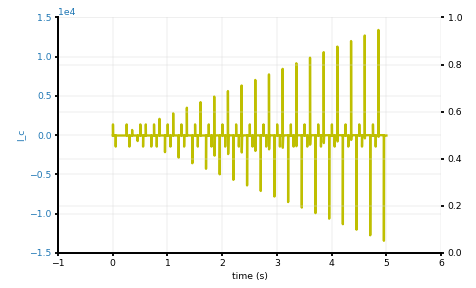

/tmp/ipykernel_18473/1333431143.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [117]:


fig, ax2 = plt.subplots()
color = 'C0'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('I_c',color = color)
#ax2.plot(t,output2.I_c, color=color)
#ax2.plot(t,output2.I_p, color='k')
#ax2.plot(t,output2.I_comp, color='r')
#ax2.plot(t,output2.I_Na, color='g')
ax2.plot(t,output.I_out, color='y')
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_xlim(2.21, 2.5)
#ax2.set_ylim(-10000, 15000)
ax1 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'C1'
#ax1.set_ylabel('v_m', color=color)  # we already handled the x-label with ax1
#ax1.plot(t,output.v_m,'--', color=color, alpha = 1)
#ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


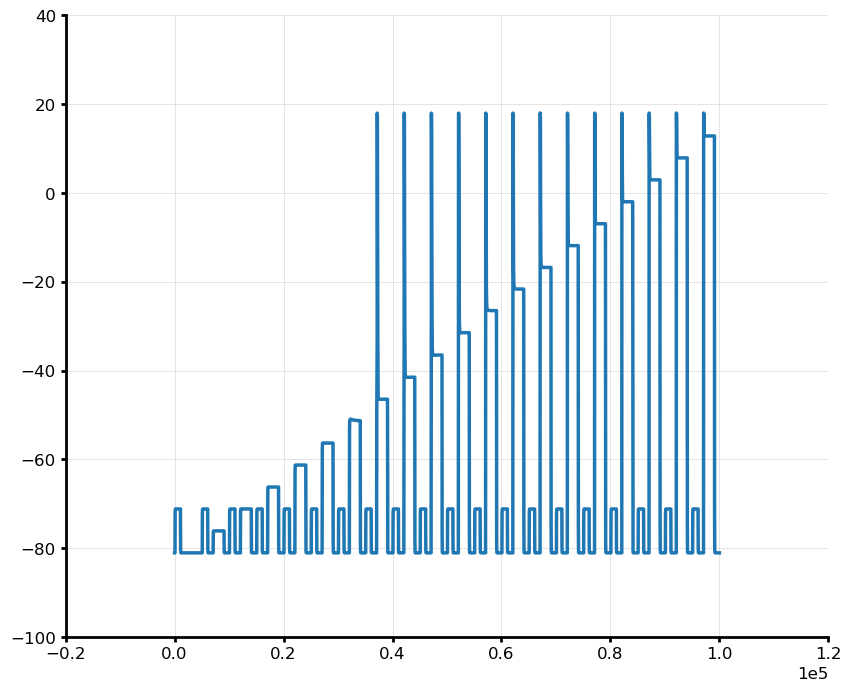

In [27]:
plt.plot(output.v_m)

In [89]:
from scipy.interpolate import interp1d

In [103]:
n=100
k_list = np.array([79*n, 1079*n, 2079*n, 4079*n])
v_list = np.array([-80., -70., -80., -80.])
k_all = k_list
v_all = v_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l*n])
    v_all = np.concatenate([v_all, v_list+[0,  0, 0, 5*l]])
v_all = np.concatenate([v_all,[-80]])

k_list_1 = np.array([77, 1077, 2077, 4077])
v_list_1 = np.array([-80.0,-70.0,-80.0, -10.0, -80.0])

dt = 5e-7
df_protocol = pd.DataFrame(np.vstack([np.array([0,*k_all]) * dt, v_all]).T, columns=['t', 'V'])

protocol = interp1d(df_protocol.t, df_protocol.V, kind='previous', bounds_error=False, fill_value=-80.)

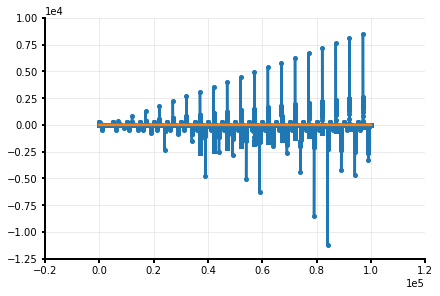

In [122]:
start = 9078
end = 9098
weight = np.zeros_like(art_data.I_out)
weight+=1   
for k in range(19):
    weight[start:end]*= 50
    start+=5000
    end+=5000
plt.plot(art_data.I_out, '.-')
plt.plot(weight)
#plt.axvline(9078, color = 'k')
#plt.axvline(9098, color = 'k')
#plt.xlim(start,end)
#plt.ylim(-200,0)

In [ ]:
#W = pd.DataFrame(np.array([art_data.t.values, weight]).T, columns=['t','w'])
#W.to_csv('../../data/sample_weights/weight_50_for_tails.csv')

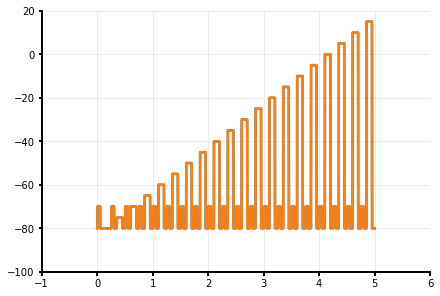

In [108]:
plt.plot(t,protocol(t))
plt.plot(df_protocol.t,df_protocol.v)

In [111]:
protocol_1 = pd.DataFrame(np.array([t,protocol(t)]).T, columns = ['t', 'v'])

In [177]:
#    A = pd.read_csv('../../data/training/2020_12_26_0000 I-V INa 36.60pF.atf', skiprows=11, delimiter = '\t', header = None)
#    B = A.values.T.reshape(A.size)[5000:]
#    t = np.arange(0, 5, 5e-5)
#    pd.DataFrame(np.array([t, B]).T, columns = ['t', 'I_out']).to_csv('../../data/training/2020_12_26_0000.csv')

In [211]:
w1 = 1
sample_weight = np.zeros(5000)+w1
w2 = 5
w3 = 10
if True:
    sample_weight[:70] += w2
    sample_weight[90:500]+= w3
    sample_weight[500:1070] += w2
    sample_weight[1090:1500] += w3
    sample_weight[1500:2070] += w2
    sample_weight[2100:2800] += 30
    sample_weight[2800:4070] += w2
    sample_weight[4090:4500] += w3
    sample_weight[4500:] += w2
sample_weight = sample_weight

In [206]:
weight = np.zeros(100000)
for k in range(20):
    weight[k*5000:(k+1)*5000] = sample_weight

In [213]:
test_data= pd.read_csv('../../data/training/2020_12_19_0035.csv')

In [207]:
plt.plot()
plt.plot(weight)

In [214]:
#W = pd.DataFrame(np.array([test_data.t.values, weight]).T, columns=['t','w'])
#W.to_csv('../../data/sample_weights/weights_1_5_10_30.csv')

In [208]:
%matplotlib notebook

<IPython.core.display.Javascript object>


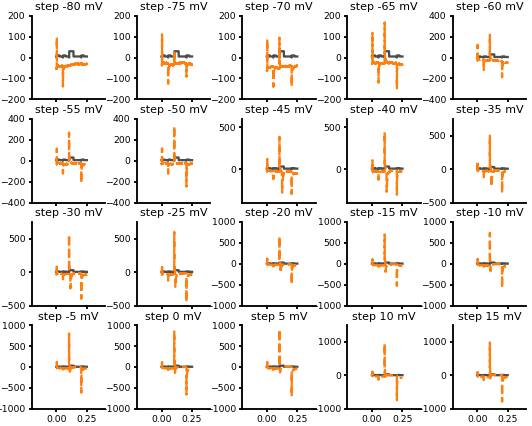

/tmp/ipykernel_18473/2509882221.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


In [212]:

    I_out = test_data # A.I_out
    real_data_all = weight
    n_sections = 20
    split_indices = np.linspace(0, len(real_data_all), n_sections + 1).astype(int)

    nrows, ncols = 4, 5

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 2,
                             sharex=True)

    
    dt = 5e-5

    colors = ['0.3', 'C1']

    i_global = 0

    for i_row in range(nrows):
        for i_col in range(ncols):
            ax = axes[i_row, i_col]
            plt.sca(ax)

            i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
            slice_current = slice(i_start, i_end)

            I_out_current = I_out[slice_current]
            data_current  = real_data_all[slice_current]
            t = np.arange(len(data_current)) * dt

            plt.plot(t, data_current,  color=colors[0])
            plt.plot(t, I_out_current, "--", color=colors[1])
            
            plt.grid()

            step_value = -80 + 5 * i_global
            title = f'step {step_value} mV'
            plt.title(title)

            i_global += 1
            #plt.xlim(0.20350,0.2065)
            #plt.ylim(-1500,1500)
            
    plt.tight_layout()